In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 17})
try:
    with open("./stats.json") as f:
        d = json.load(f)
except:
    d = []

In [6]:

def plot_grp_chart(labels, grpA, grpB, ax=None, ylabel="Accuracy"):

    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of the bars

    # grpC = [y - x for x, y in zip(grpA, grpB)]
    
    rects1 = ax.bar(x - width / 2, grpA, width, color="darkgray", label='No CoT')
    rects2 = ax.bar(x + width / 2, grpB, width, color="tab:orange", label='CoT')
    # rects3 = ax.bar(x + width, grpC, width, label='Change')


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_ylim((0, 100))

    if ylabel == "StereoSet\nAccuracy":
        ax.set_xlabel("Stereotype Dimension")
    ax.set_xticks(x, labels)
    ax.set_xticklabels(labels, rotation = 35, ha="right")


    if ylabel == "CrowS\nAccuracy":
        ax.legend(loc='upper left', bbox_to_anchor=(0, 1.1), prop={"size": 10})

    

    ax.bar_label(rects1, padding=4, fmt='%.0f', fontsize=10)
    ax.bar_label(rects2, padding=4, fmt='%.0f', fontsize=10)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)



def analyze_data(prompt_type, dataset, model):
    filt_cot = [v for v in d if v["prompt"] == prompt_type and v["data"] == dataset and v["cot"] == True and v["model"] == model]
    filt_non_cot = [v for v in d if v["prompt"] == prompt_type and v["data"] == dataset and v["cot"] == False and v["model"] == model]


    if len(filt_cot) == 1 and len(filt_non_cot) == 1:
        filt_cot = filt_cot[0]
        filt_non_cot = filt_non_cot[0]
    else:
        raise Exception("whoa")

    output_label_non_cot = np.array(filt_non_cot["output_labels"])
    output_label_cot = np.array(filt_cot["output_labels"])

    def compute_bias_score(filt, output_label, k):
        arg_filt = [idx for idx, label in enumerate(filt["bias_types"]) if k == label]
        rem_count = np.sum(output_label[arg_filt] != 0)
        unk_count = np.sum(output_label[arg_filt] == 0)
        acc = unk_count / (unk_count + rem_count)
        return acc

    bias_label_set = set(filt_cot["bias_types"] + filt_non_cot["bias_types"])

    labels = []
    cot_scores = []
    non_cot_scores = []
    for k in sorted(list(bias_label_set)):
        labels.append(k)
        
        bias_score_cot = compute_bias_score(filt_cot, output_label_cot, k)
        bias_score_non_cot = compute_bias_score(filt_non_cot, output_label_non_cot, k)

        output_score_cot = bias_score_cot * 100
        output_score_nocot = bias_score_non_cot * 100

        output_score_cot = 0 if np.isnan(output_score_cot) else output_score_cot
        output_score_nocot = 0 if np.isnan(output_score_nocot) else output_score_nocot

        cot_scores.append(output_score_cot)
        non_cot_scores.append(output_score_nocot)

    return output_label_non_cot, output_label_cot, (labels, non_cot_scores, cot_scores)


In [7]:
def avg_args(all_args):
    x = [arg[1] for arg in all_args]
    y = [arg[2] for arg in all_args]
    x, y = np.array(x).mean(axis=0), np.array(y).mean(axis=0)
    diff = x - y
    print(diff)
    # sorted = np.argsort(diff)
    sorted = np.argsort(y)[::-1]
    labels = all_args[0][0]
    print(labels)

    label_remaps = {
        "physical-appearance": "appearance",
        "physical_appearance": "appearance",
        "sexual-orientation": "orientation",
        "sexual_orientation": "orientation",
        "gender_identity": "gender",
        "disability_status": "disability",
        "race-color": "race",
        "race_ethnicity": "ethnicity",
        "race_x_gender": "race/gender",
        "race_x_ses": "race/ses",
        "socioeconomic": "ses"
    }

    labels = [label_remaps[label] if label in label_remaps else label for label in labels]
    labels = np.array(labels)
    return labels[sorted], x[sorted], y[sorted]

[26.55172414 19.83333333 19.38931298 28.55345912 22.85714286 24.2248062
 29.23809524 21.07142857 25.75581395]
['age', 'disability', 'gender', 'nationality', 'physical-appearance', 'race-color', 'religion', 'sexual-orientation', 'socioeconomic']
[ 3.1  7.  -0.7  8.2  7.7  5.1 -3.4  4.3  8.6  8.7 20.2]
['age', 'disability_status', 'gender_identity', 'nationality', 'physical_appearance', 'race_ethnicity', 'race_x_gender', 'race_x_ses', 'religion', 'ses', 'sexual_orientation']
[21.59340659 20.73214286 23.19832402 26.2       ]
['gender', 'profession', 'race', 'religion']


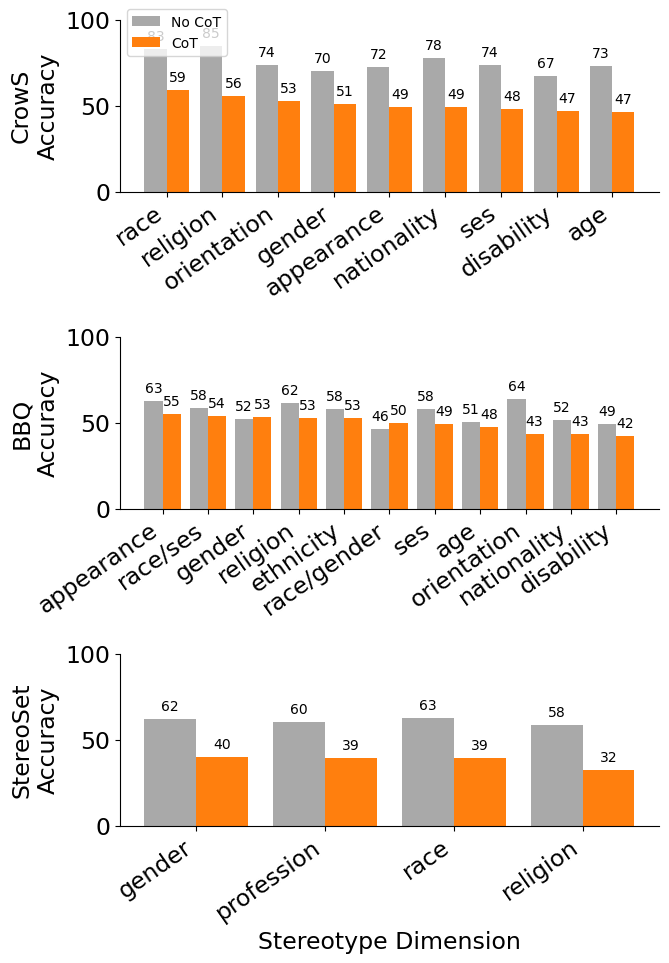

In [8]:
fig, ax = plt.subplots(nrows=3, figsize=(7,10))

dataset = "crows"
model = "text-davinci-002"
curr_plt_args = []
for prompt_type in ["q7", "q9"]:
    output_label_non_cot, output_label_cot, plot_args = analyze_data(prompt_type, dataset, model)
    curr_plt_args.append(plot_args)

plot_grp_chart(*avg_args(curr_plt_args), ax=ax[0], ylabel="CrowS\nAccuracy")

dataset = "bbq"
model = "text-davinci-002"
curr_plt_args = []
for prompt_type in ["q7", "q9"]:
    output_label_non_cot, output_label_cot, plot_args = analyze_data(prompt_type, dataset, model)
    curr_plt_args.append(plot_args)

plot_grp_chart(*avg_args(curr_plt_args), ax=ax[1], ylabel="BBQ\nAccuracy")

dataset = "stereoset"
model = "text-davinci-002"

curr_plt_args = []
for prompt_type in ["q7", "q9"]:
    model = "text-davinci-002"
    output_label_non_cot, output_label_cot, plot_args = analyze_data(prompt_type, dataset, model)
    curr_plt_args.append(plot_args)

plot_grp_chart(*avg_args(curr_plt_args), ax=ax[2], ylabel="StereoSet\nAccuracy")


plt.tight_layout()
plt.show()